In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
import logging
logging.basicConfig(level=logging.DEBUG)
from astropy.io import fits
from astropy.modeling import models, fitting
import tifffile
import numpy as np
import matplotlib.colors as mcolors
from astropy.stats import sigma_clip
logging.getLogger().setLevel(logging.INFO)
import photutils
import time
import datetime as dt
from turbustat.statistics import PowerSpectrum
from scipy import fftpack


# Colormap
dark_yellow = [ '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']

custom_cmap = mcolors.LinearSegmentedColormap.from_list("DarkYellow", dark_yellow)
gradient = np.linspace(0, 1, 256).reshape(1, -1)

In [3]:
# File containing the images
file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\Algol_1kHz_1_MMStack_Pos0.ome.tif")

immagini = tifffile.imread(file) 
# Select the specific image 
#imagenumber = 901

# Define a count per pixel threshold to find the speckles in the images
speckle_threshold=7000 #1100 #7000 #9500 #8000 #9000 #6500 #9000

# Plate scale arcseconds/pixels
plate_scale = 0.0376

# Diffraction limit of the telescope
aperture = 1.82                                                     # Aperture of the telescope (in meters)
wavelength = 700e-9                                                 # Reference wavelenght (in meters) 

diffraction_limit_radians = 2*1.22 * wavelength / aperture          # Diameter of the Airy disk
diffraction_limit_arcseconds = diffraction_limit_radians * 206265
print("Diffraction limit in arcseconds and pixels: ",diffraction_limit_arcseconds)

#Radius used to check for speckles (in pixels)
check_radius = int(diffraction_limit_arcseconds/plate_scale) #4 corrisponde al diametro del disco di airy in pixel
print ("Check radius in pixels: ", check_radius)

def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)



Diffraction limit in arcseconds and pixels:  0.19357176923076921
Check radius in pixels:  5


Shape of sum_ft: (512, 512)


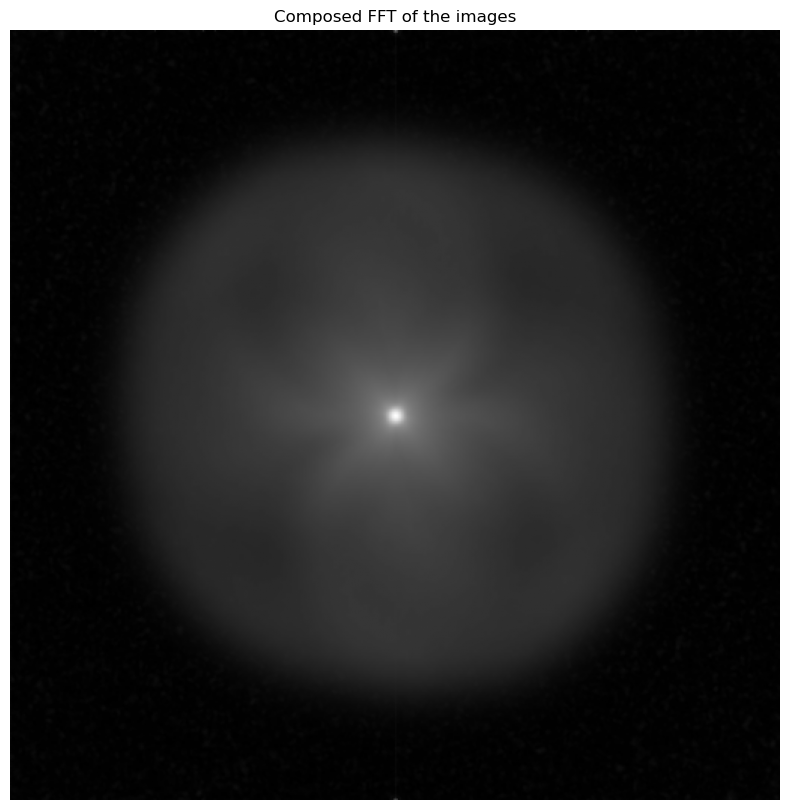

In [ ]:
sum_ft = 0

for i in range(4999):
    imagenumber = 0 + i 
    data = immagini[imagenumber]

    data_raw = data.copy()
    data_clean = data_raw.copy()
    background_level = np.median(data_raw)
    data = data_raw - background_level
    data[data < 0] = 0

    image = data.copy()
    if image.ndim == 3:
        image = image[:, :, :3].mean(axis=2) 
    elif image.ndim == 2:
        image = image  
    else:
        raise ValueError("Unexpected image dimensions: {}".format(image.shape))

    ft = calculate_2dft(image)
    sum_ft += np.abs(ft)


plt.figure(figsize=(10, 10))
plt.set_cmap('gray')
plt.imshow(np.log(sum_ft))
plt.axis("off")
plt.title("Composed FFT of the images")
plt.show()

# Save the composed FFT image to a FITS file
# Save the composed FFT image to a FITS file with headers
hdu = fits.PrimaryHDU(sum_ft)
header = hdu.header
header['NAXIS1'] = sum_ft.shape[1]  # Image width
header['NAXIS2'] = sum_ft.shape[0]  # Image height
hdul = fits.HDUList([hdu])
hdul.writeto('outputs/composed_fft.fits', overwrite=True)

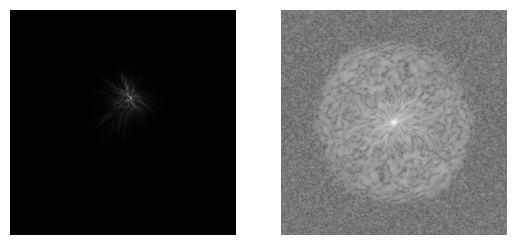

In [5]:


imagenumber = 500


data = immagini[imagenumber]
data_raw = data.copy()
data_clean = data_raw.copy()    
background_level = np.median(data_raw)
data = data_raw - background_level
data[data < 0] = 0

image = data.copy()

ft = calculate_2dft(image)
plt.subplot(121)
plt.imshow(image)
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft)))
plt.axis("off")
plt.show()




## Inverse FFT

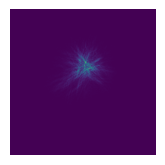

In [4]:
# Calculate the inverse Fourier transform of 
# the Fourier transform
ift = np.fft.ifftshift(ft)
ift = np.fft.ifft2(ift)
ift = np.fft.fftshift(ift)
ift = ift.real  # Take only the real part
plt.subplot(133)
plt.imshow(ift)
plt.axis("off")
plt.show()

# Power spectrum

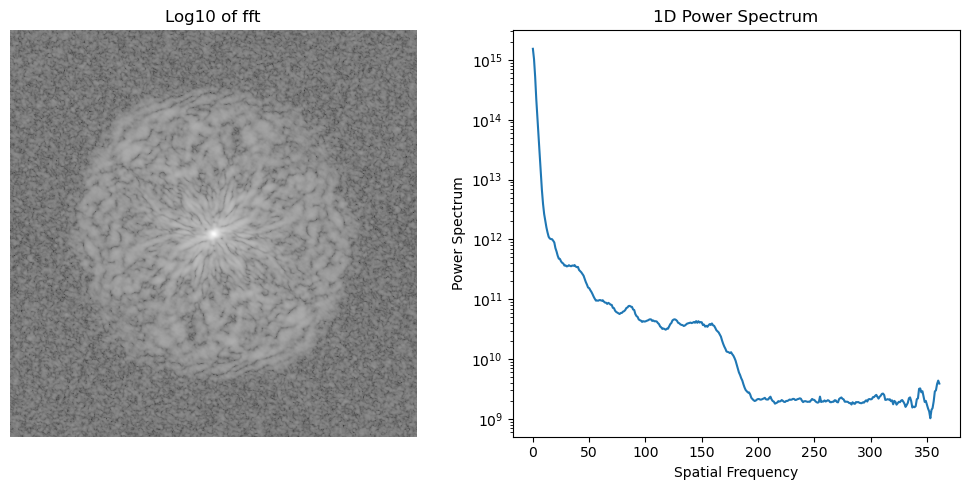

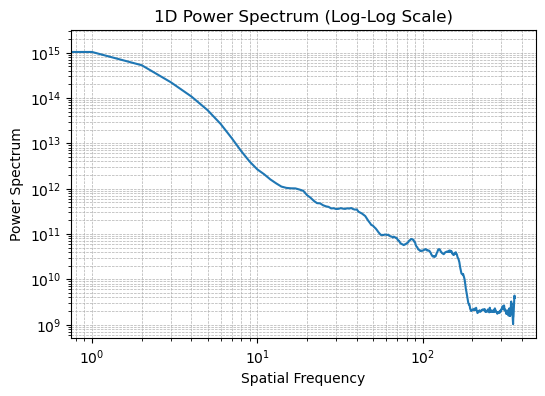

In [ ]:


imagenumber = 500
data = immagini[imagenumber]
data_raw = data.copy()
data_clean = data_raw.copy()    
background_level = np.median(data_raw)
data = data_raw - background_level
data[data < 0] = 0

image = data.copy()

# Define a function for azimuthal averaging
def azimuthalAverage(image, center=None):
	"""
	Calculate the azimuthally averaged radial profile.

	Parameters:
	-----------
	image : 2D numpy array
		The 2D image
	center : tuple of int, optional
		The (x, y) pixel coordinates used as the center. If None, the center of the image is used.

	Returns:
	--------
	radial_prof : 1D numpy array
		The azimuthally averaged radial profile
	"""
	y, x = np.indices(image.shape)
	if center is None:
		center = (x.max() / 2, y.max() / 2)

	r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
	r = r.astype(int)

	tbin = np.bincount(r.ravel(), image.ravel())
	nr = np.bincount(r.ravel())
	radial_prof = tbin / nr
	return radial_prof

# Use the azimuthalAverage function instead of radialProfile.azimuthalAverage

F1 = fftpack.fft2(image)
# Now shift the quadrants around so that low spatial frequencies are in
# the center of the 2D fourier transformed image.
F2 = fftpack.fftshift( F1 )

# 2D power spectrum
psd2D = np.abs( F2 )**2

#azimuthally averaged 1D power spectrum
psd1D = azimuthalAverage(psd2D)

# Plot the 2D power spectrum
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(psd2D), cmap='gray')
plt.title("Log10 of fft")
plt.axis("off")

# Plot the azimuthally averaged 1D power spectrum
plt.subplot(1, 2, 2)
plt.semilogy(psd1D)
plt.title("1D Power Spectrum")
plt.xlabel("Spatial Frequency")
plt.ylabel("Power Spectrum")

plt.tight_layout()
plt.show()
# Plot the azimuthally averaged 1D power spectrum in log-log scale
plt.figure(figsize=(6, 4))
plt.loglog(psd1D)
plt.title("1D Power Spectrum (Log-Log Scale)")
plt.xlabel("Spatial Frequency")
plt.ylabel("Power Spectrum")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


## Con Turbustat

In [ ]:

#header = fits.Header()
#header['NAXIS1'] = image.shape[1]  
#header['NAXIS2'] = image.shape[0]  
#header['PIXSCALE'] = plate_scale  


#with fits.open('outputs/composed_fft.fits') as hdul:
#    image = hdul[0].data

pspec = PowerSpectrum(image, header=header, distance=250 * u.pc)  
pspec.run(verbose=True, xunit=u.pix**-1 ) 

print(pspec.slope2D, pspec.slope2D_err)  
print(pspec.ellip2D, pspec.ellip2D_err)  
print(pspec.theta2D, pspec.theta2D_err)  



plt.figure(figsize=(8, 6))
plt.loglog(pspec.freqs.value, pspec.ps1D, label="Power Spectrum")
plt.xlabel("Spatial Frequency (1/pixels)")
plt.ylabel("Power")
plt.title("Power Spectrum using Turbustat")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
c:\Users\buonc\anaconda3\envs\donut\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
